# Дипломная работа

### Автор: Кузнецов С.И.

# 1.  Business Understanding

## 1.1. Цель

Построить математическую модель, разделяющую хороших и плохих клиентов.

## 1.2. Описание 

Кредитные карты являются распространенным методом контроля рисков в финансовой отрасли. Он использует личную информацию и данные, предоставленные соискателями кредитных карт, для прогнозирования вероятности будущих дефолтов и займов по кредитным картам. Банк вправе решить, выдавать ли заявителю кредитную карту. Кредитный рейтинг может объективно количественно оценить величину риска.
 
Вообще говоря, кредитные карты основаны на исторических данных. Однажды столкнувшись с большими экономическими колебаниями. Прошлые модели могут потерять свою первоначальную предсказательную силу. Логистическая модель - распространенный метод кредитного скоринга. Потому что Logistic подходит для задач бинарной классификации и может вычислять коэффициенты каждой функции. Чтобы облегчить понимание и работу, оценочная карта умножит коэффициент логистической регрессии на определенное значение (например, 100) и округлит его.
 
В настоящее время с развитием алгоритмов машинного обучения. В систему оценки кредитных карт были введены другие методы прогнозирования, такие как Boosting, Random Forest и Support Vector Machines. Однако эти методы часто не обладают хорошей прозрачностью. Может быть трудно объяснить клиентам и регулирующим органам причину отказа или принятия.

# 2. Data Understanding

## 2.1. Import Libraries 

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## 2.2. Вспомогательные функции и переменные

In [2]:
# Местонахождение файлов с исходными данными
path = './data/'

# Построение тепловой карты корреляций
def plot_correlation_map( df, filename = None ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    _ = sns.heatmap(
        corr, 
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    if filename:
        plt.savefig(filename, format = 'jpeg')
    
    
def plot_distribution( df , var , target , filename = None, **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    #facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    if filename:
        plt.savefig(filename, format = 'jpeg')

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def plot_variable_importance( X , y ):
    tree = DecisionTreeRegressor( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y, filename = None ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = False )
    imp[ imp.Importance >= 0.0001 ].plot( kind = 'barh' )
    if filename:
        plt.savefig(filename, format = 'jpeg')

## 2.3. Выгрузка данных 

In [3]:
# Данные о заявках
application_record = pd.read_csv(path + 'application_record.csv')

# Данные о выдачах
credit_record = pd.read_csv(path + 'credit_record.csv')

## 2.4. Статистика и визуализация 

### 2.4.1. Заявки

In [4]:
application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


#### 2.4.1.1. Описание переменных 

*ID* - Номер клиента

*CODE_GENDER* - Пол

*FLAG_OWN_CAR* - Имеется ли автомобиль	

*FLAG_OWN_REALTY* - Имеется ли собственность	

*CNT_CHILDREN* - Количество детей	

*AMT_INCOME_TOTAL* - Годовой доход	

*NAME_INCOME_TYPE* - Категория дохода

*NAME_EDUCATION_TYPE* - Уровень образования	

*NAME_FAMILY_STATUS* - Семейное положение	

*NAME_HOUSING_TYPE* - Проживание

*DAYS_BIRTH* -	Возраст, дн.

*DAYS_EMPLOYED* - Если отрицательное число - количество дней с момента приема на работу. Если положительное - безработный

*FLAG_MOBIL* - Наличие мобильного телефона	

*FLAG_WORK_PHONE* - Наличие рабочего телефона	

*FLAG_PHONE* - Наличие телефона

*FLAG_EMAIL* - Наличие email	

*OCCUPATION_TYPE* - Род занятий	

*CNT_FAM_MEMBERS* - Размер семьи

#### 2.4.1.2. Ключевая информация о переменных 

In [5]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [6]:
application_record.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


Переменная *FLAG_MOBIL* во всем датасете равна 1 и следовательно, не несет никакой информационной ценности.
Убираем эту переменную из датасета.

In [7]:
application_record.drop('FLAG_MOBIL', axis = 1, inplace = True)

#### 2.4.1.3. Тепловая матрица корреляций 

При построении матрицы корреляций не будем учитывать переменную ID, так как эта переменная только идентифицирует клиента и никак его не характеризует.

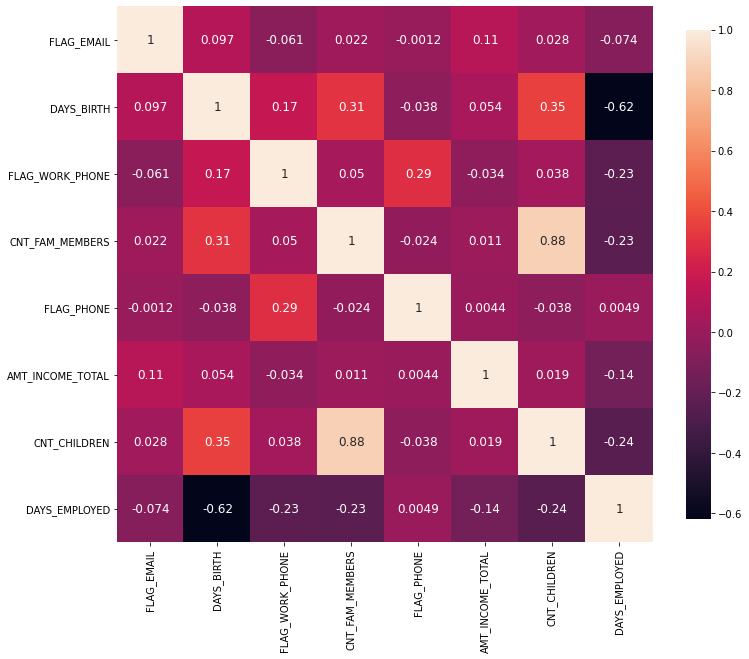

In [8]:
plot_correlation_map(application_record[set(application_record.columns.values) - {'ID'}])

**Зависимости из матрицы корреляций:**
1. Возраст клиента коррелирует с опытом работы на последнем месте. Чем больше возраст, тем больше опыт работы на последнем месте.
2. Количество детей коррелирует с общим количеством членов семьи. Но коэффициент корреляции не равен 1, значит в выборке есть неполные семьи, либо некорректно заполненные данные.

In [9]:
application_record[application_record.DAYS_EMPLOYED > 0].DAYS_EMPLOYED.unique()

array([365243])

Т.е. если человек безработный, то в переменная *DAYS_EMPLOYED* принимает значение, равное *365243*

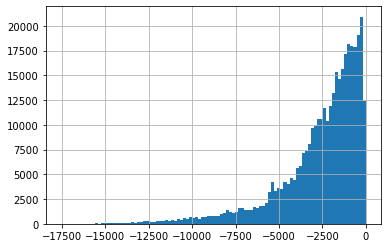

In [10]:
_ = application_record[application_record.DAYS_EMPLOYED <= 0].DAYS_EMPLOYED.hist(bins = 100)

In [11]:
application_record['UNEMPLOYED'] = \
application_record.DAYS_EMPLOYED.apply(lambda x: 1 if x >= 0 else 0)
application_record['UNEMPLOYED'].value_counts()

0    363228
1     75329
Name: UNEMPLOYED, dtype: int64

In [12]:
application_record['CNT_ADULT_FAM_MEMBERS'] = application_record.CNT_FAM_MEMBERS - application_record.CNT_CHILDREN

In [13]:
application_record['CNT_ADULT_FAM_MEMBERS'].value_counts()

 2.0    336551
 1.0    101907
 0.0        58
-1.0        36
-2.0         5
Name: CNT_ADULT_FAM_MEMBERS, dtype: int64

In [14]:
application_record['FAMILY_STATUS'] = \
application_record['CNT_ADULT_FAM_MEMBERS'].apply(lambda x: \
                                                  'NON_CORRECT' if x <= 0 else 'NON_FULL' if x == 1 else 'FULL')

application_record['FAMILY_STATUS'].value_counts()

FULL           336551
NON_FULL       101907
NON_CORRECT        99
Name: FAMILY_STATUS, dtype: int64

В наборе заявок имеются клиенты, подавшие более одной заявки. Добавим параметр, характеризующий количество заявок от одного клиента.

In [15]:
num_of_applications = application_record.ID.value_counts().to_dict()
application_record['NUM_OF_APPLICATIONS'] = application_record.ID.apply(num_of_applications.get)
application_record['NUM_OF_APPLICATIONS'].value_counts()

1    438463
2        94
Name: NUM_OF_APPLICATIONS, dtype: int64

### 2.4.2. Выдачи

In [16]:
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


#### 2.4.2.1. Описание переменных: 

*ID* - Номер клиента

*MONTHS_BALANCE* - Месяц. Месяц извлеченных данных является отправной точкой, в обратном порядке, 0 - текущий месяц, -1 - предыдущий месяц и т.д.

*STATUS* - Данные о просроченных платежах:
* *0*: 1-29 дней с просрочкой 
* *1*: 30-59 дней с просрочкой 
* *2*: 60-89 дней с просрочкой 
* *3*: 90-119 дней с просрочкой 
* *4*: 120-149 дней с просрочкой 
* *5*: просроченной или безнадежной задолженностью, списание более чем 150 дней 
* *C*: выплачено в этом месяце 
* *X*: Нет ссуды за месяц

In [17]:
credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


#### 2.4.2.2. Количество клиентов в выборке 

In [18]:
credit_record.ID.unique().shape

(45985,)

In [19]:
credit_record.groupby('STATUS')[['MONTHS_BALANCE']].count()

,MONTHS_BALANCE
STATUS,
0,383120
1,11090
2,868
3,320
4,223
5,1693
C,442031
X,209230


#### 2.4.2.3. Целевая фича 

В зависимости от поставленной задачи можно в качестве целевой переменной выбрать:
* Наличие хотя бы одной просрочки за всю историю
* Наличие хотя бы одной просрочки в течение определенного срока с момента получения кредитной карты
* Наличие определенного количества просрочек за некоторый период

В качестве целевой фичи мы выберем **наличие хотя бы одной просрочки более 30 дней в течение полугода с момента получения карты**

In [20]:
customers_life_time = credit_record.groupby('ID')['MONTHS_BALANCE'].min().to_dict()
credit_record['LIFE_TIME'] = credit_record.ID.apply(customers_life_time.get)
credit_record['HALF_YEAR'] = credit_record['LIFE_TIME'] + 6
credit_record = credit_record[credit_record.LIFE_TIME <= -6]
credit_record = credit_record[(credit_record.MONTHS_BALANCE >= credit_record.LIFE_TIME) &
                             (credit_record.MONTHS_BALANCE <= credit_record.HALF_YEAR)]

In [21]:
good_customers = dict()
for customer in tqdm(credit_record.groupby('ID')):
    good_customers[customer[0]] = 1
    if '1' in set(customer[1]['STATUS']):
        good_customers[customer[0]] = 0
    if '2' in set(customer[1]['STATUS']):
        good_customers[customer[0]] = 0
    if '3' in set(customer[1]['STATUS']):
        good_customers[customer[0]] = 0
    if '4' in set(customer[1]['STATUS']):
        good_customers[customer[0]] = 0
    if '5' in set(customer[1]['STATUS']):
        good_customers[customer[0]] = 0

  0%|          | 0/41390 [00:00<?, ?it/s]

In [22]:
application_record['GOOD_CUSTOMER'] = application_record.ID.apply(good_customers.get)
application_record = application_record[~np.isnan(application_record.GOOD_CUSTOMER)]
application_record.shape

(32567, 22)

In [23]:
application_record.GOOD_CUSTOMER.value_counts()

1.0    30152
0.0     2415
Name: GOOD_CUSTOMER, dtype: int64

### 2.4.3. Датасет с целевой фичей 

In [24]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 434812
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     32567 non-null  int64  
 1   CODE_GENDER            32567 non-null  object 
 2   FLAG_OWN_CAR           32567 non-null  object 
 3   FLAG_OWN_REALTY        32567 non-null  object 
 4   CNT_CHILDREN           32567 non-null  int64  
 5   AMT_INCOME_TOTAL       32567 non-null  float64
 6   NAME_INCOME_TYPE       32567 non-null  object 
 7   NAME_EDUCATION_TYPE    32567 non-null  object 
 8   NAME_FAMILY_STATUS     32567 non-null  object 
 9   NAME_HOUSING_TYPE      32567 non-null  object 
 10  DAYS_BIRTH             32567 non-null  int64  
 11  DAYS_EMPLOYED          32567 non-null  int64  
 12  FLAG_WORK_PHONE        32567 non-null  int64  
 13  FLAG_PHONE             32567 non-null  int64  
 14  FLAG_EMAIL             32567 non-null  int64  
 15  O

In [25]:
application_record.NUM_OF_APPLICATIONS.value_counts()

1    32567
Name: NUM_OF_APPLICATIONS, dtype: int64

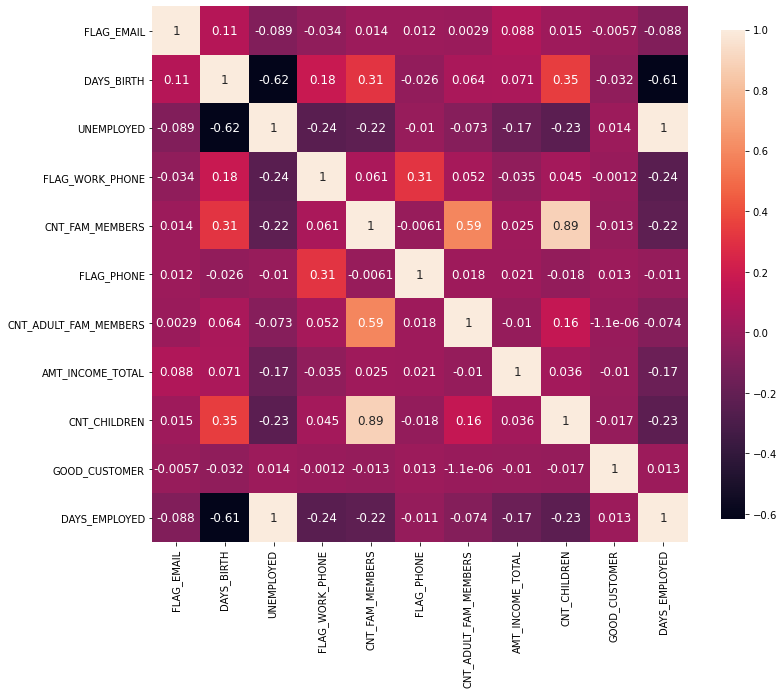

In [26]:
plot_correlation_map(application_record[set(application_record.columns.values) - {'ID', 'NUM_OF_APPLICATIONS'}])

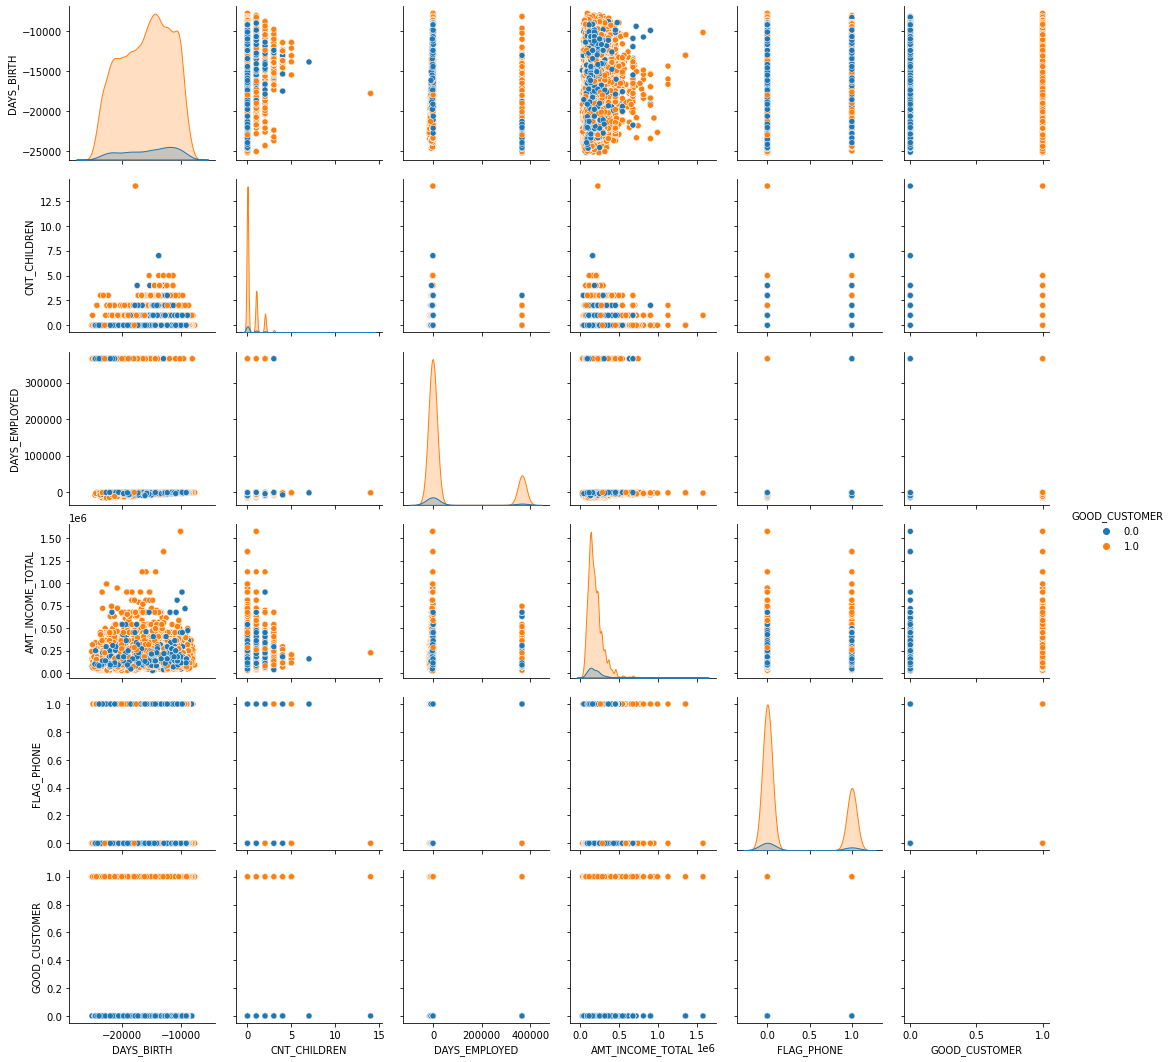

In [27]:
sns.pairplot(data = application_record, 
             vars = ['DAYS_BIRTH', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'FLAG_PHONE' , 'GOOD_CUSTOMER'],
             hue = 'GOOD_CUSTOMER',
            )

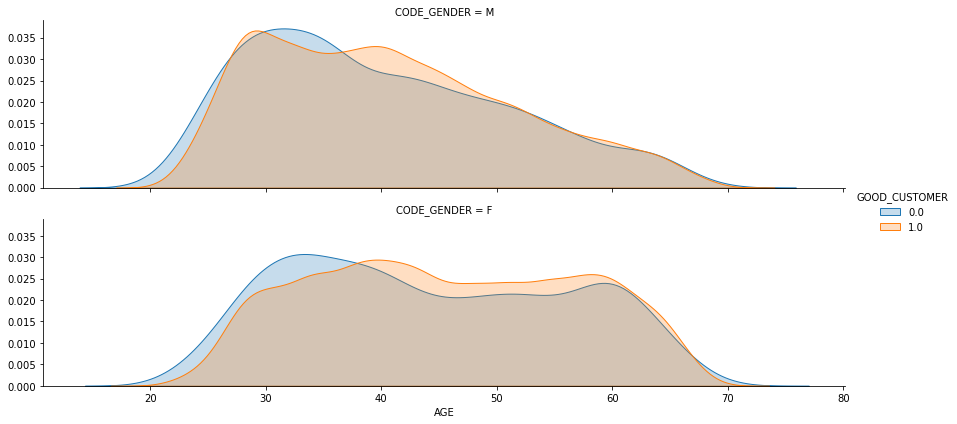

In [28]:
application_record['AGE'] = - application_record.DAYS_BIRTH / 365
plot_distribution(application_record, var = 'AGE', row = 'CODE_GENDER', target = 'GOOD_CUSTOMER', 
                  filename = 'age_gender.jpeg')

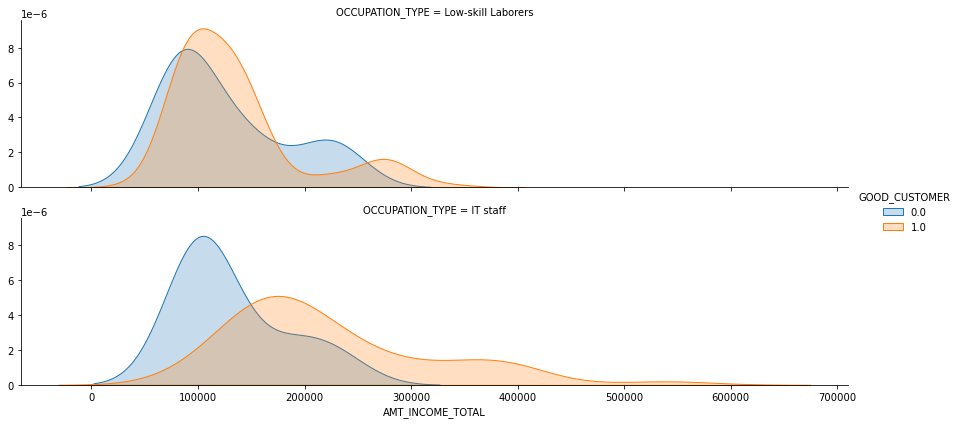

In [29]:
plot_distribution(application_record[application_record.OCCUPATION_TYPE.isin({'Low-skill Laborers', 'IT staff'})],
                  var = 'AMT_INCOME_TOTAL', row = 'OCCUPATION_TYPE', target = 'GOOD_CUSTOMER',
                 filename = 'occupation_type.jpeg')

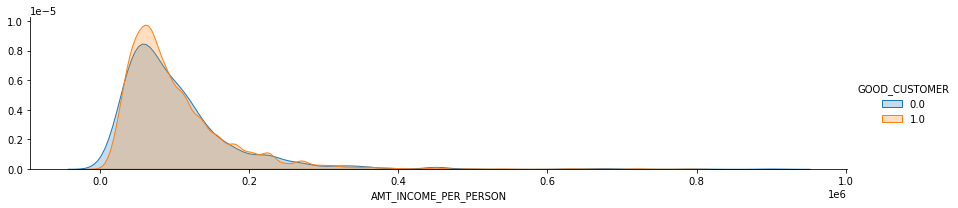

In [30]:
application_record['AMT_INCOME_PER_PERSON'] = application_record['AMT_INCOME_TOTAL'] / application_record['CNT_FAM_MEMBERS']
plot_distribution(application_record, var = 'AMT_INCOME_PER_PERSON', target = 'GOOD_CUSTOMER')

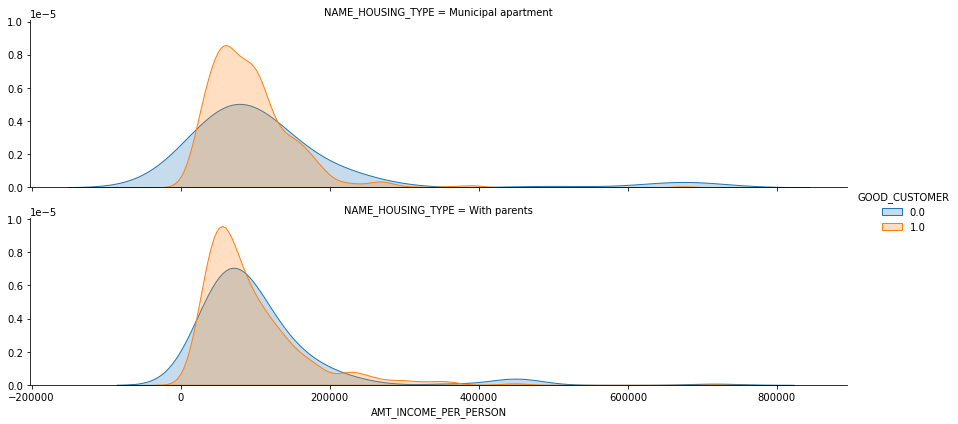

In [31]:
plot_distribution(application_record[application_record.NAME_HOUSING_TYPE.isin({'With parents', 'Municipal apartment'})], 
                  var = 'AMT_INCOME_PER_PERSON', row = 'NAME_HOUSING_TYPE', target = 'GOOD_CUSTOMER',
                 filename = 'housing_type.jpeg')

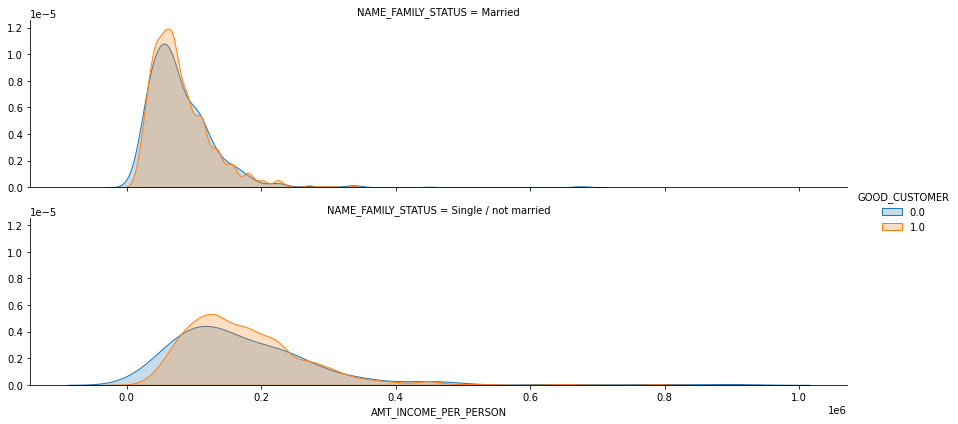

In [32]:
plot_distribution(application_record[application_record.NAME_FAMILY_STATUS.isin({'Married', 'Single / not married'})],
                  var = 'AMT_INCOME_PER_PERSON', row = 'NAME_FAMILY_STATUS', target = 'GOOD_CUSTOMER',
                 filename = 'family_status.jpeg')

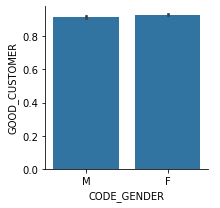

In [33]:
plot_categories(application_record, cat = 'CODE_GENDER', target = 'GOOD_CUSTOMER')

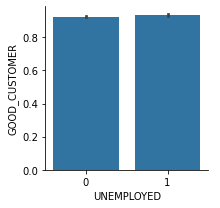

In [34]:
plot_categories(application_record, cat = 'UNEMPLOYED', target = 'GOOD_CUSTOMER')

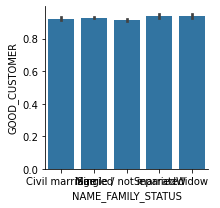

In [35]:
plot_categories(application_record, cat = 'NAME_FAMILY_STATUS', target = 'GOOD_CUSTOMER')

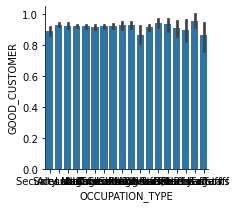

In [36]:
plot_categories(application_record, cat = 'OCCUPATION_TYPE', target = 'GOOD_CUSTOMER')

# 3. Data Preparation

In [37]:
application_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 434812
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     32567 non-null  int64  
 1   CODE_GENDER            32567 non-null  object 
 2   FLAG_OWN_CAR           32567 non-null  object 
 3   FLAG_OWN_REALTY        32567 non-null  object 
 4   CNT_CHILDREN           32567 non-null  int64  
 5   AMT_INCOME_TOTAL       32567 non-null  float64
 6   NAME_INCOME_TYPE       32567 non-null  object 
 7   NAME_EDUCATION_TYPE    32567 non-null  object 
 8   NAME_FAMILY_STATUS     32567 non-null  object 
 9   NAME_HOUSING_TYPE      32567 non-null  object 
 10  DAYS_BIRTH             32567 non-null  int64  
 11  DAYS_EMPLOYED          32567 non-null  int64  
 12  FLAG_WORK_PHONE        32567 non-null  int64  
 13  FLAG_PHONE             32567 non-null  int64  
 14  FLAG_EMAIL             32567 non-null  int64  
 15  O

## 3.1. Преобразуем категориальные фичи в числовые 

Выведем категориальные фичи.

In [38]:
categorial_features = []
for c in application_record.columns.values:
    if application_record[c].dtype == 'O':
        categorial_features.append(c)
        print(c + ':')
        print(application_record[c].value_counts())
        print('\n')

CODE_GENDER:
F    21797
M    10770
Name: CODE_GENDER, dtype: int64


FLAG_OWN_CAR:
N    19996
Y    12571
Name: FLAG_OWN_CAR, dtype: int64


FLAG_OWN_REALTY:
Y    21793
N    10774
Name: FLAG_OWN_REALTY, dtype: int64


NAME_INCOME_TYPE:
Working                 16820
Commercial associate     7615
Pensioner                5426
State servant            2695
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64


NAME_EDUCATION_TYPE:
Secondary / secondary special    21996
Higher education                  8944
Incomplete higher                 1258
Lower secondary                    339
Academic degree                     30
Name: NAME_EDUCATION_TYPE, dtype: int64


NAME_FAMILY_STATUS:
Married                 22588
Single / not married     4180
Civil marriage           2580
Separated                1881
Widow                    1338
Name: NAME_FAMILY_STATUS, dtype: int64


NAME_HOUSING_TYPE:
House / apartment      29092
With parents            1563
Municipal apartment     1021
R

Категориальную фичу *"OCCUPATION_TYPE"* заменим средним значением целевой переменной по соответствующей категории. Для всех остальных категориальных фич применим метод *get_dummies()*

In [39]:
# Средние значения целевой переменной по категориям "OCCUPATION_TYPE"
mean_good_cust_by_OT = application_record.groupby('OCCUPATION_TYPE').GOOD_CUSTOMER.mean().to_dict()
application_record['OCCUPATION_TYPE_MEAN_GOOD_CUSTS'] = \
application_record.OCCUPATION_TYPE.apply(mean_good_cust_by_OT.get)

In [40]:
application_record.OCCUPATION_TYPE_MEAN_GOOD_CUSTS.value_counts()

0.923822    5474
0.921827    3262
0.932614    3057
0.922826    2760
0.918905    1936
0.924409    1270
0.925959    1121
0.915761    1104
0.930605     562
0.893458     535
0.929167     480
0.942953     298
0.867550     151
0.907285     151
0.933824     136
0.894737      76
0.957143      70
0.862745      51
Name: OCCUPATION_TYPE_MEAN_GOOD_CUSTS, dtype: int64

In [41]:
application_record_categories = \
pd.get_dummies(application_record[[f for f in categorial_features if f != 'OCCUPATION_TYPE']])
application_record = application_record.join(application_record_categories)
application_record.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32567 entries, 0 to 434812
Data columns (total 55 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 32567 non-null  int64  
 1   CODE_GENDER                                        32567 non-null  object 
 2   FLAG_OWN_CAR                                       32567 non-null  object 
 3   FLAG_OWN_REALTY                                    32567 non-null  object 
 4   CNT_CHILDREN                                       32567 non-null  int64  
 5   AMT_INCOME_TOTAL                                   32567 non-null  float64
 6   NAME_INCOME_TYPE                                   32567 non-null  object 
 7   NAME_EDUCATION_TYPE                                32567 non-null  object 
 8   NAME_FAMILY_STATUS                                 32567 non-null  object 
 9   NAME_

## 3.2. Работа с прорущенными значениями

Припущенные значения имеются только у переменной *'OCCUPATION_TYPE_MEAN_GOOD_CUSTS'*. 
Заполним эти значения средней величиной целевой переменной.

In [42]:
application_record.OCCUPATION_TYPE_MEAN_GOOD_CUSTS.fillna(value = application_record.GOOD_CUSTOMER.mean(), 
                                                          inplace = True)

## 3.3. Сборка датасета для построения модели 

### 3.3.1. Выбираем фичи, которые войдут в финальный датасет

In [43]:
# Фичи, на которых будем строить модель
features_list = [f for f in application_record.columns.values if application_record[f].dtype != 'O' \
                and f not in {'ID', 'GOOD_CUSTOMER'}]

# Целевая фича
target = 'GOOD_CUSTOMER'

features_list

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'UNEMPLOYED',
 'CNT_ADULT_FAM_MEMBERS',
 'NUM_OF_APPLICATIONS',
 'AGE',
 'AMT_INCOME_PER_PERSON',
 'OCCUPATION_TYPE_MEAN_GOOD_CUSTS',
 'CODE_GENDER_F',
 'CODE_GENDER_M',
 'FLAG_OWN_CAR_N',
 'FLAG_OWN_CAR_Y',
 'FLAG_OWN_REALTY_N',
 'FLAG_OWN_REALTY_Y',
 'NAME_INCOME_TYPE_Commercial associate',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_State servant',
 'NAME_INCOME_TYPE_Student',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Academic degree',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Incomplete higher',
 'NAME_EDUCATION_TYPE_Lower secondary',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Civil marriage',
 'NAME_FAMILY_STATUS_Married',
 'NAME_FAMILY_STATUS_Separated',
 'NAME_FAMILY_STATUS_Single / not married',
 'NAME_FAMILY_STATUS_Widow',
 'NAME_HOUSING_TYPE_Co-op apartment',
 'NAME_HOU

### 3.3.2. Формируем обучающую и тестовую выборки 

In [44]:
application_record['SUBSET'] = np.random.choice(['train', 'test'], 
                                                size = application_record.shape[0],
                                               p = [.7, .3])
X_train = application_record[application_record.SUBSET == 'train'][features_list]
X_test = application_record[application_record.SUBSET == 'test'][features_list]
y_train = application_record[application_record.SUBSET == 'train'][target]
y_test = application_record[application_record.SUBSET == 'test'][target]

Применим масштабирование

In [45]:
mms = MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train)
X_test_scaled = mms.transform(X_test)

Сбалансируем выборку

In [46]:
oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_scaled, y_train)
X_test_balanced, y_test_balanced = oversample.fit_resample(X_test_scaled, y_test)

# 4. Modelling

## 4.1. Выбор метрики

Выберем коэффициент Джини как метрику качества построенной модели

## 4.2. Дерево решений 

### 4.2.1. Подбор параметров 

In [47]:
mdl_dt = DecisionTreeClassifier()
params_dt = {
    'max_depth': np.arange(2, 20),
    'min_samples_split': np.arange(2, 20),
    'max_features': np.arange(2, 20)
}
mdl_dec_tree = GridSearchCV(mdl_dt, params_dt, scoring = 'roc_auc', n_jobs = -1, cv = 5)

In [48]:
%%time
mdl_dec_tree.fit(X_train, y_train)
mdl_dec_tree.best_params_

CPU times: user 1min 3s, sys: 13.3 s, total: 1min 17s
Wall time: 3min 14s


{'max_depth': 10, 'max_features': 17, 'min_samples_split': 9}

### 4.2.2. Построение модели 

Исходная выборка

In [62]:
mdl_dt = DecisionTreeClassifier(
    max_depth = mdl_dec_tree.best_params_['max_depth'],
    max_features = mdl_dec_tree.best_params_['max_features'],
    min_samples_split = mdl_dec_tree.best_params_['min_samples_split']
)
mdl_dt.fit(X_train, y_train)
gini_dt = 1 - 2 * roc_auc_score(y_test, mdl_dt.predict_proba(X_test)[:,0])

print('GINI: {:.4f}'.format(gini_dt))

GINI: 0.1797


Масштабированная выборка

In [63]:
mdl_dt_scaled = DecisionTreeClassifier(
    max_depth = mdl_dec_tree.best_params_['max_depth'],
    max_features = mdl_dec_tree.best_params_['max_features'],
    min_samples_split = mdl_dec_tree.best_params_['min_samples_split']
)
mdl_dt_scaled.fit(X_train_scaled, y_train)
gini_dt_scaled = 1 - 2 * roc_auc_score(y_test, mdl_dt_scaled.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_dt_scaled))

GINI: 0.2487


Сбалансированная выборка

In [64]:
mdl_dt_balanced = DecisionTreeClassifier(
    max_depth = mdl_dec_tree.best_params_['max_depth'],
    max_features = mdl_dec_tree.best_params_['max_features'],
    min_samples_split = mdl_dec_tree.best_params_['min_samples_split']
)
mdl_dt_balanced.fit(X_train_balanced, y_train_balanced)
gini_dt_balanced = 1 - 2 * roc_auc_score(y_test, mdl_dt_balanced.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_dt_balanced))

GINI: 0.2717


### 4.2.3. Визуализация дерева решений

Для визуализации был использован сервис https://dreampuf.github.io/GraphvizOnline/

In [65]:
print(tree.export_graphviz(mdl_dt_balanced, feature_names = X_train.columns.values))

digraph Tree {
node [shape=box] ;
0 [label="CNT_FAM_MEMBERS <= 0.071\ngini = 0.5\nsamples = 42020\nvalue = [21010, 21010]"] ;
1 [label="OCCUPATION_TYPE_MEAN_GOOD_CUSTS <= 0.74\ngini = 0.496\nsamples = 27948\nvalue = [12740, 15208]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="FLAG_PHONE <= 0.999\ngini = 0.498\nsamples = 25913\nvalue = [12210, 13703]"] ;
1 -> 2 ;
3 [label="CNT_CHILDREN <= 0.0\ngini = 0.5\nsamples = 19176\nvalue = [9621, 9555]"] ;
2 -> 3 ;
4 [label="OCCUPATION_TYPE_MEAN_GOOD_CUSTS <= 0.67\ngini = 0.5\nsamples = 17790\nvalue = [8687, 9103]"] ;
3 -> 4 ;
5 [label="NAME_INCOME_TYPE_State servant <= 0.004\ngini = 0.498\nsamples = 16503\nvalue = [7762, 8741]"] ;
4 -> 5 ;
6 [label="DAYS_EMPLOYED <= 0.021\ngini = 0.496\nsamples = 14719\nvalue = [6670, 8049]"] ;
5 -> 6 ;
7 [label="NAME_FAMILY_STATUS_Single / not married <= 0.408\ngini = 0.284\nsamples = 431\nvalue = [74, 357]"] ;
6 -> 7 ;
8 [label="AMT_INCOME_PER_PERSON <= 0.067\ngini = 0.129\nsample

### 4.2.4. Важность фичей

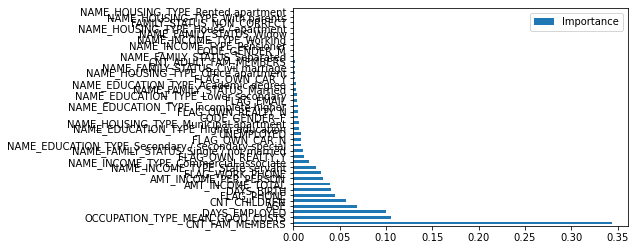

In [66]:
plot_model_var_imp(mdl_dt_balanced, X_train, y_train)

## 4.3. Линейная и логистическая регрессии 

### 4.3.1. Подбор параметров для метода Лассо 

In [67]:
mdl_ls = Lasso()
params_ls = {
    'alpha': np.arange(1, 100) * 0.1,
    'fit_intercept': [True, False],
    'normalize': [True, False]
}
mdl_lasso = GridSearchCV(mdl_ls, params_ls, scoring = 'roc_auc', n_jobs = -1, cv = 5)

In [68]:
%%time
mdl_lasso.fit(X_train, y_train)
mdl_lasso.best_params_

CPU times: user 14.6 s, sys: 3.24 s, total: 17.8 s
Wall time: 43.3 s


{'alpha': 0.1, 'fit_intercept': True, 'normalize': False}

### 4.3.2. Построение модели 

Исходная выборка

In [72]:
mdl_ls = Lasso(
    alpha = mdl_lasso.best_params_['alpha'],
    fit_intercept = mdl_lasso.best_params_['fit_intercept'],
    normalize = mdl_lasso.best_params_['normalize']
)
mdl_ls.fit(X_train, y_train)
gini_ls = 2 * roc_auc_score(y_test, mdl_ls.predict(X_test)) - 1

print('GINI: {:.4f}'.format(gini_ls))

GINI: 0.0663


Масштабированная выборка

In [73]:
mdl_ls_scaled = Lasso(
    alpha = mdl_lasso.best_params_['alpha'],
    fit_intercept = mdl_lasso.best_params_['fit_intercept'],
    normalize = mdl_lasso.best_params_['normalize']
)
mdl_ls_scaled.fit(X_train_scaled, y_train)
gini_ls_scaled = 2 * roc_auc_score(y_test, mdl_ls_scaled.predict(X_test_scaled)) - 1

print('GINI: {:.4f}'.format(gini_ls_scaled))

GINI: 0.0000


Сбалансированная выборка

In [74]:
mdl_ls_balanced = Lasso(
    alpha = mdl_lasso.best_params_['alpha'],
    fit_intercept = mdl_lasso.best_params_['fit_intercept'],
    normalize = mdl_lasso.best_params_['normalize']
)
mdl_ls_balanced.fit(X_train_balanced, y_train_balanced)
gini_ls_balanced = 2 * roc_auc_score(y_test, mdl_ls_balanced.predict(X_test_scaled)) - 1

print('GINI: {:.4f}'.format(gini_ls))

GINI: 0.0663


### 4.3.3. Выбор фичей для логистической регрессии 

In [75]:
best_features = X_train.columns.values[abs(mdl_ls.coef_) >=1e-8]
best_features

array(['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'AMT_INCOME_PER_PERSON'],
      dtype=object)

### 4.3.4. Построение логистической регрессии

In [76]:
mdl_logreg = LogisticRegression()
mdl_logreg.fit(X_train[best_features], y_train)
gini_logreg = 1 - 2 * roc_auc_score(y_test, mdl_logreg.predict_proba(X_test[best_features])[:,0])

print('GINI: {:.2f}'.format(gini_logreg))

GINI: 0.06


##  4.4. Градиентный бустинг

### 4.4.3. Выбор оптимальных параметров модели

In [77]:
mdl_gb = XGBClassifier()

mdl_grad_boosting = CalibratedClassifierCV(mdl_gb, method='isotonic', cv = 5)
mdl_grad_boosting.fit(X_train, y_train)

[01:40:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:40:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:40:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:40:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=None,
                                                    booster=None,
                                                    colsample_bylevel=None,
                                                    colsample_bynode=None,
                                                    colsample_bytree=None,
                                                    gamma=None, gpu_id=None,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=None,
                                                    max_delta_step=None,
                                                    max_depth=None,
                                                    min_child_weight=None,
                                                    missing=nan,
                                                   

Исходная выборка

In [78]:
mdl_gb = XGBClassifier(importance_type='gain', n_estimators=100)
mdl_gb.fit(X_train, y_train)
gini_gb = 1 - 2 * roc_auc_score(y_test, mdl_gb.predict_proba(X_test)[:,0])

print('GINI: {:.4f}'.format(gini_gb))

[01:40:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GINI: 0.5250


Масштабированная выборка

In [79]:
mdl_gb_scaled = XGBClassifier(importance_type='gain', n_estimators=100)
mdl_gb_scaled.fit(X_train_scaled, y_train)
gini_gb_scaled = 1 - 2 * roc_auc_score(y_test, mdl_gb_scaled.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_gb_scaled))

[01:40:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GINI: 0.5249


Сбалансированная выборка

In [80]:
mdl_gb_balanced = XGBClassifier(importance_type='gain', n_estimators=100)
mdl_gb_balanced.fit(X_train_balanced, y_train_balanced)
gini_gb_balanced = 1 - 2 * roc_auc_score(y_test, mdl_gb_balanced.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_gb_balanced))

[01:40:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
GINI: 0.4373


## 4.5. Метод ближайших соседей 

In [81]:
mdl_knn = KNeighborsClassifier()
params_knn = {
    'n_neighbors': np.arange(1, 20) * 5
}
mdl_knn_classifier = GridSearchCV(mdl_knn, params_knn, scoring = 'roc_auc', n_jobs = -1, cv = 5)

In [82]:
%%time
mdl_knn_classifier.fit(X_train, y_train)
mdl_knn_classifier.best_params_

CPU times: user 367 ms, sys: 76 ms, total: 443 ms
Wall time: 4.33 s


{'n_neighbors': 50}

In [83]:
mdl_knn = KNeighborsClassifier(n_neighbors = mdl_knn_classifier.best_params_['n_neighbors'])
mdl_knn.fit(X_train, y_train)
gini_knn = 1 - 2 * roc_auc_score(y_test, mdl_knn.predict_proba(X_test)[:,0])

print('GINI: {:.4f}'.format(gini_knn))


GINI: 0.2415


Масштабированная выборка

In [84]:
mdl_knn_scaled = KNeighborsClassifier(n_neighbors = mdl_knn_classifier.best_params_['n_neighbors'])
mdl_knn_scaled.fit(X_train_scaled, y_train)
gini_knn_scaled = 1 - 2 * roc_auc_score(y_test, mdl_knn_scaled.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_knn_scaled))

GINI: 0.2616


Сбалансированная выборка

In [85]:
mdl_knn_balanced = KNeighborsClassifier(n_neighbors = mdl_knn_classifier.best_params_['n_neighbors'])
mdl_knn_balanced.fit(X_train_balanced, y_train_balanced)
gini_knn_balanced = 1 - 2 * roc_auc_score(y_test, mdl_knn_balanced.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_knn_balanced))

GINI: 0.3419


## 4.6. Метод опорных векторов 

 Исходная выборка

In [88]:
mdl_svc = SVC(probability = True)
mdl_svc.fit(X_train, y_train)
gini_svc = 1 - 2 * roc_auc_score(y_test, mdl_svc.predict_proba(X_test)[:,0])

print('GINI: {:.4f}'.format(gini_svc))

GINI: -0.0026


Масштабированная выборка

In [89]:
mdl_svc_scaled = SVC(probability = True)
mdl_svc_scaled.fit(X_train_scaled, y_train)
gini_svc_scaled = 1 - 2 * roc_auc_score(y_test, mdl_svc_scaled.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_svc_scaled))

GINI: 0.2945


Сбалансированная выборка

In [94]:
mdl_svc_balanced = SVC(probability = True)
mdl_svc_balanced.fit(X_train_balanced, y_train_balanced)
gini_svc_balanced = 1 - 2 * roc_auc_score(y_test, mdl_svc_balanced.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_svc_balanced))

GINI: 0.2388


## 4.7. Нейронная сеть

Исходная выборка

In [90]:
mdl_mpl = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=10000)
mdl_mpl.fit(X_train, y_train)
gini_mpl = 1 - 2 * roc_auc_score(y_test, mdl_mpl.predict_proba(X_test)[:,0])

print('GINI: {:.4f}'.format(gini_mpl))

GINI: 0.0057


Масштабированная выборка

In [91]:
mdl_mpl_scaled = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=10000)
mdl_mpl_scaled.fit(X_train_scaled, y_train)
gini_mpl_scaled = 1 - 2 * roc_auc_score(y_test, mdl_mpl.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_mpl_scaled))

GINI: -0.0555


Сбалансированная выборка

In [92]:
mdl_mpl_balanced = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=10000)
mdl_mpl_balanced.fit(X_train_balanced, y_train_balanced)
gini_mpl_balanced = 1 - 2 * roc_auc_score(y_test, mdl_mpl.predict_proba(X_test_scaled)[:,0])

print('GINI: {:.4f}'.format(gini_mpl_balanced))

GINI: -0.0555


# 5. Evaluation

## 5.1. Оценка качества построенных моделей

Построим  ROC-кривые для каждой из моделей.

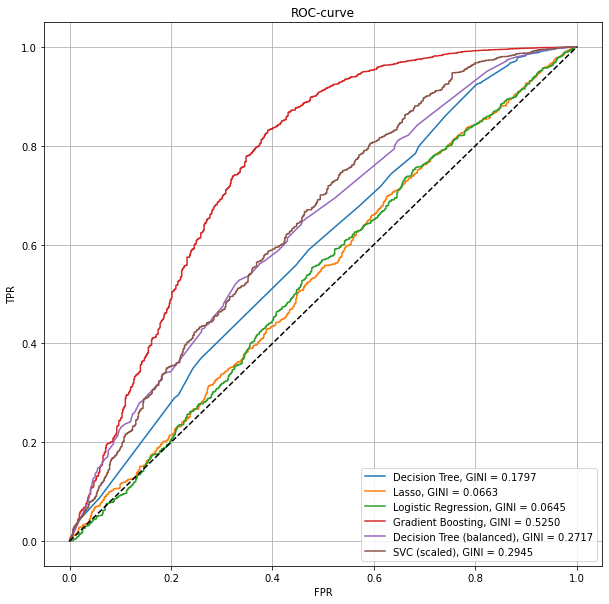

In [99]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, mdl_dt.predict_proba(X_test)[:, 1])
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, mdl_ls.predict(X_test))
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, mdl_logreg.predict_proba(X_test[best_features])[:, 1])
fpr_gb, tpr_gb, _ = roc_curve(y_test, mdl_gb.predict_proba(X_test)[:, 1])
fpr_dt_balanced, tpr_dt_balanced, _ = roc_curve(y_test, mdl_dt_balanced.predict_proba(X_test_scaled)[:, 1])
fpr_svc_scaled, tpr_svc_scaled, _ = roc_curve(y_test, mdl_svc_scaled.predict_proba(X_test_scaled)[:, 1])


plt.figure(figsize = (10, 10))

plt.plot(fpr_dt, tpr_dt, label = 'Decision Tree, GINI = {:.4f}'.format(gini_dt))
plt.plot(fpr_lasso, tpr_lasso, label = 'Lasso, GINI = {:.4f}'.format(gini_ls))
plt.plot(fpr_logreg, tpr_logreg, label = 'Logistic Regression, GINI = {:.4f}'.format(gini_logreg))
plt.plot(fpr_gb, tpr_gb, label = 'Gradient Boosting, GINI = {:.4f}'.format(gini_gb))
plt.plot(fpr_dt_balanced, tpr_dt_balanced, label = 'Decision Tree (balanced), GINI = {:.4f}'.format(gini_dt_balanced))
plt.plot(fpr_svc_scaled, tpr_svc_scaled, label = 'SVC (scaled), GINI = {:.4f}'.format(gini_svc_scaled))
plt.plot([0, 1], [0, 1], '--k')
plt.legend(loc = 'lower right')
plt.title('ROC-curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.savefig('ROC.jpeg', format = 'jpeg')

Видно, что самая лучшая модель - модель на основе **градиентного бустинга**. Однако эта модель не является интерпретируемой. Самая лучшая из интерпретируемых моделей - **дерево решений**, построенная на масштабированной сбалансированной выборке.

# 6. Deployment

## 6.1. Способы внедрения модели 

Существует несколько способов внедрения построенных моделей:
1. Создание SQL-запроса, возвращающего предсказание уровня риска. При принятии решения этот запрос будет вызываться. 
2. Создание python-процедуры и встраивание ее в сервис, который будет по API возвращать оценку риска.
3. Реализация модели на каком-либо еще языке программирования.